# Subspace Clustering

image come from [https://www.pexels.com/photo/animal-biology-bloom-blossom-460067/](https://www.pexels.com/photo/animal-biology-bloom-blossom-460067/)

image (alex-tai-FKf4ixzVz_8-unsplash.jpg) Photo by Alex Tai on Unsplash came from [https://unsplash.com/photos/FKf4ixzVz_8](https://unsplash.com/photos/FKf4ixzVz_8)

>References: Robust Recovery of Subspace Structures by Low-Rank Representation. arXiv:1010.2955v6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import itertools

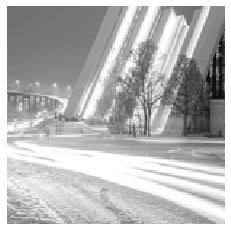

In [2]:
# Img = PIL.Image.open("./animal-biology-bloom-blossom-460067.jpg")
Img = PIL.Image.open("./alex-tai-FKf4ixzVz_8-unsplash.jpg")

Img = Img.resize((Img.size[0] // 16, Img.size[1] // 16))
minw = np.min(Img.size)
maxw = np.max(Img.size)
Img = Img.crop(((maxw-minw)//2, (maxw-minw)//2, minw, minw))
Img = Img.convert("L")

Img = np.asarray(Img)
plt.imshow(Img, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

## Approach

$$
\min \| Z \|_* + \lambda \| E \|, \\ \text{s.t. } X = A Z + E
$$

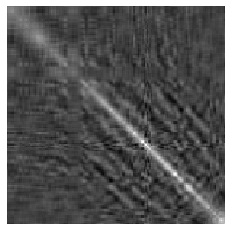

(150, 150)

In [3]:
X = Img / 255.0
U, S, V = np.linalg.svd(X)

tV = V[0:16].T

plt.imshow(tV @ tV.T, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

A = U * S
A.shape

## SVD thresholding

error less than 0.1 at 44


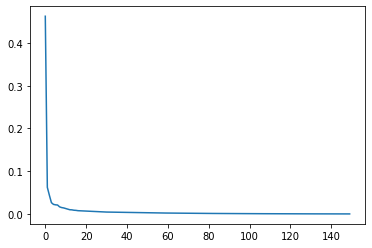

In [4]:
es = 0
sumS = np.sum(S)
for i, s in enumerate(S):
    es += s
    if es / sumS > 0.9:
        print("error less than 0.1 at", i)
        break
        
plt.plot(S / sumS)
plt.show()

shrinkage operator

In [5]:
def shrinkage(tS, esp):
    less = tS < -esp
    above = tS > esp
    equ = ~(less + above)
    
    tS[less] += esp
    tS[above] -= esp
    tS[equ] = 0
    return tS

## Optimize

In [6]:
imgW, imgH = Img.shape

Z, J, E, Y1, Y2 = np.zeros((5, imgW, imgH), dtype=np.float32)
mu = 1e-6
muMax = 1e+6
rho = 1.1
esplion = 1e-8
lam = 1e-2

In [7]:
A = X
I = np.eye(A.shape[1])

# %debug
for epho in itertools.count(0,1):
    # J
    tU, tS, tV = np.linalg.svd(Z + Y2/mu, full_matrices=False)
    shrinkage(tS, 1/mu)
    J = np.matmul(tU * tS, tV)
    
    # Z 
    tiA = np.linalg.inv(I + A.T @ A)
    Z = tiA @ (A.T @ (X - E) + J + (A.T @ Y1 - Y2)/mu)
    # E
    E = X - np.matmul(A, Z) + Y1/mu
    shrinkage(E, lam/mu)
    # Y1 and Y2
    tY1 = X - A @ Z - E
    tY2 = Z - J
    Y1 += mu * tY1
    Y2 += mu * tY2
    
    # update mu
    mu = min(rho*mu, muMax)
    
    check0 = np.max(np.sum(np.abs(tY1), 1))
    check1 = np.max(np.sum(np.abs(tY2), 1))
    if epho % 20 == 0:
        print("epho", epho,  check0, check1)
        
    # check 
    if check0 < esplion and check1 < esplion:
        break

epho 0 3.8491823080503895 3.424632939758605
epho 20 3.849182284773194 3.4246329252400165
epho 40 3.849182350773665 3.4246330515163534
epho 60 3.8491823451875877 3.424632931841877
epho 80 3.849182339885431 3.4246328121586336
epho 100 3.5931966471498638 3.3488473040530526
epho 120 0.716513776465632 2.371446889845713
epho 140 0.048367021296610545 0.11832460313277011
epho 160 0.0037533504735431664 0.01078545020108961
epho 180 0.00032776896057104646 0.0011748737767726621
epho 200 5.020749488018474e-05 0.00013835506117841406
epho 220 8.339892338601545e-06 2.4546036918732697e-05
epho 240 1.254376283968236e-06 3.1922712240362646e-06
epho 260 1.8662089105046187e-07 5.044677225593327e-07
epho 280 2.8273545307953204e-08 7.607013465320246e-08
epho 300 7.924037138484385e-09 1.9965589145723786e-08
epho 320 4.774658270493743e-09 1.1968834136503038e-08


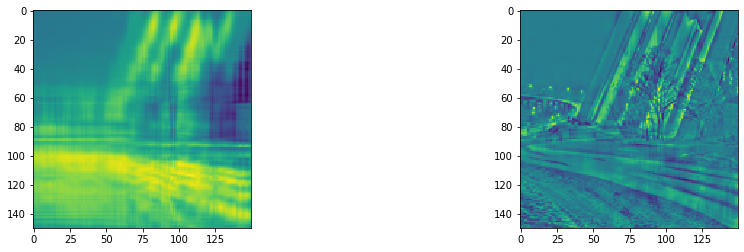

In [8]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.imshow(A @ Z)
plt.subplot(1,2,2)
plt.imshow(E)
plt.show()

## Subspace Segmentation

In [9]:
zU, zS, zV = np.linalg.svd(Z)

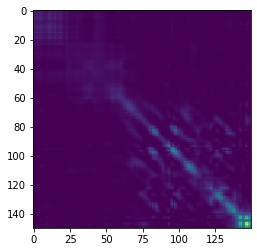

In [10]:
W = zU * np.sqrt(zS)
W = np.matmul(W, W.T)
W = np.square(W)

plt.imshow(W)
plt.show()

## Estimating the Subspace Number K

In [11]:
_D = np.sum(W, 1)
_Dsqrt = 1/np.sqrt(_D)
_Dmat = np.diag(_Dsqrt)

LaplicanM = np.eye(_Dmat.shape[0]) - _Dmat @ W @ _Dmat

eigL = np.linalg.eigvals(LaplicanM)


In [12]:
tau = 3e-1
feig = np.ones_like(eigL)
eigbelow = eigL < tau

feig[eigbelow] = np.log2(1 + np.square(eigL[eigbelow])/(tau*tau))

numK = len(eigL) - np.floor(np.sum(feig))
print(numK)

2.0
